In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
model_checkpoint = "microsoft/swin-tiny-patch4-window7-224" # pre-trained model from which to fine-tune
batch_size = 32 # batch size for training and evaluation

In [3]:
!pip install -q datasets transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 78.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 67.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 104.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 28.3 MB/s eta 0:00:00


In [4]:
from transformers.utils import send_example_telemetry

send_example_telemetry("image_classification_notebook", framework="pytorch")

In [5]:
from datasets import load_dataset 

# load a custom dataset from local/remote files or folders using the ImageFolder feature

# option 1: local/remote files (supporting the following formats: tar, gzip, zip, xz, rar, zstd)
dataset = load_dataset("imagefolder", data_files="/content/gdrive/MyDrive/data/datasetImages.zip")

# note that you can also provide several splits:
# dataset = load_dataset("imagefolder", data_files={"train": ["path/to/file1", "path/to/file2"], "test": ["path/to/file3", "path/to/file4"]})

# note that you can push your dataset to the hub very easily (and reload afterwards using load_dataset)!
# dataset.push_to_hub("nielsr/eurosat")
# dataset.push_to_hub("nielsr/eurosat", private=True)

# option 2: local folder
# dataset = load_dataset("imagefolder", data_dir="path_to_folder")

# option 3: just load any existing dataset from the hub, like CIFAR-10, FashionMNIST ...
# dataset = load_dataset("cifar10")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-f8e637ea71bc6531/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
from datasets import load_metric

metric = load_metric("accuracy")

<ipython-input-6-350fcae91df9>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 37500
    })
})

In [8]:
example = dataset["train"][10]
example

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=150x150 at 0x7F76FDDCACA0>,
 'label': 0}

In [9]:
!unzip gdrive/My\ Drive/data/dataset.zip

Archive:  gdrive/My Drive/data/dataset.zip


In [15]:
import os
import numpy as np
import cv2
input_dir = 'dataset/val/vort'
output_dir = 'dataset2/val/vort'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for filename in os.listdir(input_dir):
    if filename.endswith(".npy"):
        # Load the .npy file
        image = np.load(os.path.join(input_dir, filename))
        # Reshape the image and convert to uint8
        image = np.squeeze(image)
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
        # Save the image as a .jpg file
        output_path = os.path.join(
            output_dir, os.path.splitext(filename)[0] + ".jpg")
        cv2.imwrite(output_path, image)


In [ ]:
!zip -r /content/datasetImages.zip /content/dataset2

In [17]:
!cp /content/datasetImages.zip /content/gdrive/MyDrive/data

In [10]:
dataset["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['no', 'sphere', 'vort'], id=None)}

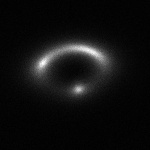

In [11]:
example['image']

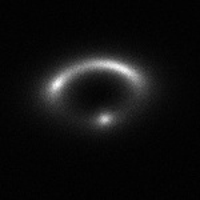

In [12]:
example['image'].resize((200, 200))

In [13]:
example['label']

0

In [14]:
dataset["train"].features["label"]

ClassLabel(names=['no', 'sphere', 'vort'], id=None)

In [15]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[2]

'vort'

In [16]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)
feature_extractor

/usr/local/lib/python3.9/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [17]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
# train_transforms = Compose(
#         [
#             RandomResizedCrop(feature_extractor.size),
#             RandomHorizontalFlip(),
#             ToTensor(),
#             normalize,
#         ]
#     )

# val_transforms = Compose(
#         [
#             Resize((feature_extractor.size["height"], feature_extractor.size["width"])),
#             CenterCrop(feature_extractor.size["height"]),
#             ToTensor(),
#             normalize,
#         ]
#     )

# def preprocess_train(example_batch):
#     """Apply train_transforms across a batch."""
#     example_batch["pixel_values"] = [
#         train_transforms(image.convert("RGB")) for image in example_batch["image"]
#     ]
#     return example_batch

# def preprocess_val(example_batch):
#     """Apply val_transforms across a batch."""
#     example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
#     return example_batch

height, width = feature_extractor.size["height"], feature_extractor.size["width"]

train_transforms = Compose(
        [
            RandomResizedCrop((height, width)),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize((height, width)),
            CenterCrop((height, width)),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch


In [18]:
# split up training into training + validation
splits = dataset["train"].train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

In [19]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [20]:
train_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=150x150 at 0x7F76FE1F0970>,
 'label': 2,
 'pixel_values': tensor([[[-2.0494, -2.0494, -2.0665,  ..., -2.0665, -2.0665, -2.0665],
          [-2.0494, -2.0494, -2.0665,  ..., -2.0665, -2.0665, -2.0665],
          [-2.0494, -2.0494, -2.0494,  ..., -2.0665, -2.0665, -2.0665],
          ...,
          [-2.0665, -2.0665, -2.0837,  ..., -2.0837, -2.0837, -2.0837],
          [-2.0665, -2.0665, -2.0665,  ..., -2.0665, -2.0665, -2.0665],
          [-2.0665, -2.0665, -2.0665,  ..., -2.0665, -2.0665, -2.0665]],
 
         [[-1.9657, -1.9657, -1.9832,  ..., -1.9832, -1.9832, -1.9832],
          [-1.9657, -1.9657, -1.9832,  ..., -1.9832, -1.9832, -1.9832],
          [-1.9657, -1.9657, -1.9657,  ..., -1.9832, -1.9832, -1.9832],
          ...,
          [-1.9832, -1.9832, -2.0007,  ..., -2.0007, -2.0007, -2.0007],
          [-1.9832, -1.9832, -1.9832,  ..., -1.9832, -1.9832, -1.9832],
          [-1.9832, -1.9832, -1.9832,  ..., -1.9832, -1

In [21]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-eurosat",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

In [33]:
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [34]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [35]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn
)

In [36]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.747000,0.668240,0.708267
1,0.679400,0.630913,0.731200
2,0.653700,0.534853,0.774933
4,0.596000,0.541475,0.783200
4,0.574000,0.468181,0.812533
5,0.540100,0.432995,0.824800
6,0.535900,0.420790,0.832000
8,0.501800,0.417768,0.838400
8,0.529700,0.410436,0.836000
9,0.508700,0.396029,0.843733


***** train metrics *****
  epoch                    =         9.97
  total_flos               = 7790994680GF
  train_loss               =       0.5963
  train_runtime            =   1:25:00.56
  train_samples_per_second =       66.169
  train_steps_per_second   =        0.516


In [37]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =       9.97
  eval_accuracy           =     0.8437
  eval_loss               =      0.396
  eval_runtime            = 0:00:24.27
  eval_samples_per_second =    154.493
  eval_steps_per_second   =      4.861


In [76]:
# Assuming that the model_checkpoint variable contains the path to the saved checkpoint
model_name = model_checkpoint.split("/")[-1]
model.save_pretrained(f"{model_name}-finetuned-eurosat-weights")


In [38]:
!cp -r /content/swin-tiny-patch4-window7-224-finetuned-eurosat /content/gdrive/MyDrive/data